In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import heapq
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Step 1

Find a dataset with:
* Sensitive attributes
* A target variable to train a classifier on

Examples:
* Adults [Gender, Income]
* COMPAS [RACE, ScoreText]
* German Credit Dataset [Gender, Creditability] (https://online.stat.psu.edu/stat857/node/222/)
* Student Dropout [Gender / Nationality, Whether Dropout or not] (https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)
* Diabetes Dataset [Gender / Race, readmitted] (https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)

In [27]:
df = pd.read_csv("../datasets/cox-violent-parsed.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [28]:
df.shape, df.columns

((18316, 52),
 Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
        'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
        'juv_misd_count', 'juv_other_count', 'priors_count',
        'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
        'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
        'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
        'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
        'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
        'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
        'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
        'decile_score.1', 'score_text', 'screening_date',
        'v_type_of_assessment', 'v_decile_score', 'v_score_text',
        'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
        'start', 'end', 'event'],
       dtype='object'))

In [29]:
df["score_text"].value_counts() # Target

score_text
Low       8597
Medium    5082
High      4614
Name: count, dtype: int64

In [30]:
df["race"].value_counts() # Sensitive Attr

race
African-American    9791
Caucasian           6086
Hispanic            1451
Other                860
Asian                 71
Native American       57
Name: count, dtype: int64

Reduce number of minorities

In [6]:
# new_df_m = df[df["gender"] == "Male"]
# new_df_f = df[df["gender"] == "Female"].sample(frac=0.1)
# df = pd.concat((new_df_f, new_df_m))
# df = df.sample(frac=1)
# df = df.reset_index()
# df.shape

(34269, 16)

In [7]:
# df["gender"].value_counts()

gender
Male      32650
Female     1619
Name: count, dtype: int64

Pre-process columns:
* Categorical
* Scale

Remove sensitive attribute.

### COMPAS

In [31]:
# For compas
df = df.drop(columns=['last','first','out_custody','in_custody','c_offense_date','decile_score.1','priors_count.1','c_case_number','start','end','event','screening_date','c_case_number','juv_other_count','r_days_from_arrest','id','r_charge_degree','r_offense_date', 'vr_case_number','r_case_number','r_jail_out','c_arrest_date','r_charge_desc','r_jail_in', 'violent_recid','vr_charge_degree','vr_offense_date','vr_charge_desc'])
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['days_in_jail'] = abs((df['c_jail_out'] - df['c_jail_in']).dt.days)
df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'])
df['v_screening_date'] = pd.to_datetime(df['v_screening_date'])

/tmp/ipykernel_3469618/528926956.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_3469618/528926956.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
/tmp/ipykernel_3469618/528926956.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'])
/tmp/ipykernel_3469618/528926956.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['

In [32]:
le = LabelEncoder()

columns = [
    'c_charge_degree', 
    'score_text', 
    'v_score_text', 
    'c_jail_in', 
    'c_jail_out', 
    'c_charge_desc', 
    'days_in_jail',
    'sex',
    'age_cat',
    'race'
]

df["compas_screening_date"] = pd.to_datetime(df["compas_screening_date"])
df["compas_screening_date"] = df['compas_screening_date'].apply(lambda x:x.toordinal())
df["dob"] = pd.to_datetime(df["dob"])
df["dob"] = df['dob'].apply(lambda x:x.toordinal())
df["v_screening_date"] = pd.to_datetime(df["v_screening_date"])
df["v_screening_date"] = df['v_screening_date'].apply(lambda x:x.toordinal())


for col in columns:
    df[col] = le.fit_transform(df[col])

for col in df.columns:
    df.dropna(inplace=True)

df.reset_index(inplace=True)

s = df["race"]
X = df.drop(columns=["race", 
                     "name", 
                     "type_of_assessment", 
                     "v_type_of_assessment", 
                     "v_score_text",
                     "score_text", 
                     "index",     
                     'v_decile_score',
                     'decile_score'])
y = df["score_text"]

X.head()

/tmp/ipykernel_3469618/1628067882.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dob"] = pd.to_datetime(df["dob"])


,compas_screening_date,sex,dob,age,age_cat,juv_fel_count,juv_misd_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,v_screening_date,days_in_jail
0,735094,1,710869,69,1,0,0,0,-1.0,3207,2548,1.0,4,20,0,0,735094,0
1,735094,1,710869,69,1,0,0,0,-1.0,3207,2548,1.0,4,20,0,0,735094,0
2,734895,1,723567,34,0,0,0,0,-1.0,475,401,1.0,4,200,1,1,734895,10
3,734972,1,726966,24,2,0,0,4,-1.0,1933,1401,1.0,4,369,1,0,734972,1
4,734972,1,726966,24,2,0,0,4,-1.0,1933,1401,1.0,4,369,1,0,734972,1


### Adults

In [6]:
le = LabelEncoder()

adult_columns = ["workclass", 
           "education", 
           "marital-status", 
           "occupation", 
           "relationship", 
           "race", 
           "gender", 
           "native-country", 
           "income"]
# adults_drop = ["gender", "index"]
adults_drop = ["gender", "income"]

for col in adult_columns:
    df[col] = le.fit_transform(df[col])

s = df["gender"]
X = df.drop(columns=adults_drop)
y = df["income"]

X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country
0,25,4,226802,1,7,4,7,3,2,0,0,40,39
1,38,4,89814,11,9,2,5,0,4,0,0,50,39
2,28,2,336951,7,12,2,11,0,4,0,0,40,39
3,44,4,160323,15,10,2,7,0,2,7688,0,40,39
4,18,0,103497,15,10,4,0,3,4,0,0,30,39


### Final

In [33]:
X = StandardScaler().fit_transform(X)
X.shape, y.shape

((17019, 18), (17019,))

# Step 2

Train a classifier on the dataset:
* LogisticRegression
* Simple NN (MLP)
* Decision Tree

TODO: Split to train/test and check the test score instead of train score.

In [34]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, indices, test_size=0.33, random_state=0, shuffle=True, )
clf = MLPClassifier(hidden_layer_sizes=(20, 30, 20), random_state=0, max_iter=300, verbose=1).fit(X, y)
# clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

Iteration 1, loss = 1.23309256
Iteration 2, loss = 0.88086223
Iteration 3, loss = 0.84751004
Iteration 4, loss = 0.83661385
Iteration 5, loss = 0.82891233
Iteration 6, loss = 0.82412813
Iteration 7, loss = 0.81945142
Iteration 8, loss = 0.81651107
Iteration 9, loss = 0.81332736
Iteration 10, loss = 0.81094354
Iteration 11, loss = 0.80934008
Iteration 12, loss = 0.80583669
Iteration 13, loss = 0.80467826
Iteration 14, loss = 0.80188656
Iteration 15, loss = 0.79872242
Iteration 16, loss = 0.79653227
Iteration 17, loss = 0.79589664
Iteration 18, loss = 0.79322869
Iteration 19, loss = 0.79198501
Iteration 20, loss = 0.79071391
Iteration 21, loss = 0.78950311
Iteration 22, loss = 0.78675491
Iteration 23, loss = 0.78569812
Iteration 24, loss = 0.78392771
Iteration 25, loss = 0.78242935
Iteration 26, loss = 0.77990262
Iteration 27, loss = 0.77999200
Iteration 28, loss = 0.77695638
Iteration 29, loss = 0.77600865
Iteration 30, loss = 0.77423092
Iteration 31, loss = 0.77365651
Iteration 32, los

0.7196012106106463

Sort the points based on the accuracy of the classifier

In [35]:
scores = clf.predict_proba(X_test)[list(y_test.reset_index().index), y_test.to_list()]
scores.shape

(5617,)

In [36]:
BOTTOM_K_ERROR_REGION = 0.2 # The ratio of error region
ratio = int(BOTTOM_K_ERROR_REGION * len(scores))
err_region_ind = np.argpartition(scores, ratio)[:ratio]
err_region = scores[err_region_ind]
err_region.shape, scores.shape

((1123,), (5617,))

Visualize the error region in 2D

In [ ]:
pca = PCA(n_components=2)
x_test_reduced = pca.fit_transform(X_test)
y_test_reduced = np.zeros(y_test.shape)
y_test_reduced[err_region_ind] = 1
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=y_test_reduced, s=4)
ax[0].set_title("Error region (Yellow is error region)")
ax[1].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=np.bitwise_not(s[ind_test]), s=4)
ax[1].set_title("Demographic groups (Yellow is minority)")

# Step 3
Find high skews

In [37]:
err_region_one_hot = np.zeros(y_test.shape)
err_region_one_hot[err_region_ind] = 1
np.unique(err_region_one_hot, return_counts=True)

(array([0., 1.]), array([4494, 1123]))

Approach

* Sample from the test data
* For each pair of points (a, b) in this sample, where a \in err_region and b \notin err_region calc skew
* Report highest skews

In [38]:
def skew(f, points):
    p_f = np.dot(points, f)
    mean = np.mean(p_f)
    sd = np.std(p_f)
    median = np.median(p_f)
    return ((mean - median) / sd)

def get_line(first_point, second_point):
    vec = second_point - first_point
    v_hat = vec / np.linalg.norm(vec)
    return v_hat

In [39]:
TEST_SAMPLE_RATIO = 0.1
X_test.shape, err_region_one_hot.shape

((5617, 18), (5617,))

In [40]:
ind_sample = np.random.choice(len(X_test), size=int(len(X_test) * TEST_SAMPLE_RATIO), replace=False)
sample_test = X_test[ind_sample]
sample_err = err_region_one_hot[ind_sample]
sample_test.shape, sample_err.shape, np.unique(sample_err, return_counts=True)

((561, 18), (561,), (array([0., 1.]), array([445, 116])))

In [41]:
err_reg_portion = sample_test[sample_err == 1]
not_err_reg_portion = sample_test[sample_err == 0]

heap = []
counter = 0
MAX = len(err_reg_portion)

for a in err_reg_portion:
    counter += 1
    print(f"{counter} / {MAX}")
    for b in not_err_reg_portion:
        f = get_line(a, b)
        sk = skew(f, X_train)
        heapq.heappush(heap, (-sk, tuple(f)))

1 / 116
2 / 116
3 / 116
4 / 116
5 / 116
6 / 116
7 / 116
8 / 116
9 / 116
10 / 116
11 / 116
12 / 116
13 / 116
14 / 116
15 / 116
16 / 116
17 / 116
18 / 116
19 / 116
20 / 116
21 / 116
22 / 116
23 / 116
24 / 116
25 / 116
26 / 116
27 / 116
28 / 116
29 / 116
30 / 116
31 / 116
32 / 116
33 / 116
34 / 116
35 / 116
36 / 116
37 / 116
38 / 116
39 / 116
40 / 116
41 / 116
42 / 116
43 / 116
44 / 116
45 / 116
46 / 116
47 / 116
48 / 116
49 / 116
50 / 116
51 / 116
52 / 116
53 / 116
54 / 116
55 / 116
56 / 116
57 / 116
58 / 116
59 / 116
60 / 116
61 / 116
62 / 116
63 / 116
64 / 116
65 / 116
66 / 116
67 / 116
68 / 116
69 / 116
70 / 116
71 / 116
72 / 116
73 / 116
74 / 116
75 / 116
76 / 116
77 / 116
78 / 116
79 / 116
80 / 116
81 / 116
82 / 116
83 / 116
84 / 116
85 / 116
86 / 116
87 / 116
88 / 116
89 / 116
90 / 116
91 / 116
92 / 116
93 / 116
94 / 116
95 / 116
96 / 116
97 / 116
98 / 116
99 / 116
100 / 116
101 / 116
102 / 116
103 / 116
104 / 116
105 / 116
106 / 116
107 / 116
108 / 116
109 / 116
110 / 116
111 / 11

In [42]:
def get_high_skews(heap, top_k=10):
        count = 0
        heap = heap.copy()
        while True:
            count = count + 1
            try:
                yield heapq.heappop(heap)
                if count == top_k:
                    break
            except:
                break

top_skews = list(get_high_skews(heap, top_k=5))

Visualize high skewed directions

In [43]:
gender = s[ind_train]

In [44]:
gender.value_counts()

race
0    6154
2    3782
3     877
5     516
1      45
4      28
Name: count, dtype: int64

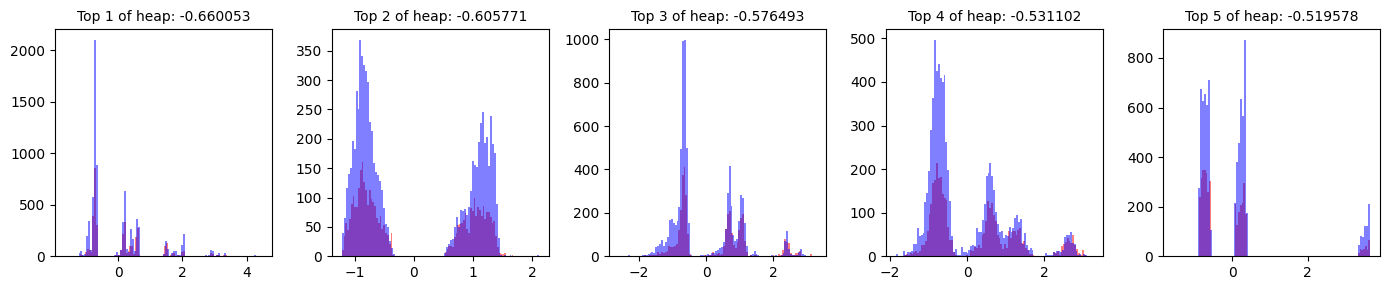

In [45]:
fig, axs = plt.subplots(1, len(top_skews), figsize=(14, 3))
ind = 0
fil = gender.apply(lambda x: x in [2])
for ax in axs:
    ax.hist(np.dot(X_train[fil], top_skews[ind][1]), color="red", alpha=0.5, bins=100, label="Female")
    ax.hist(np.dot(X_train[np.logical_not(fil)], top_skews[ind][1]), color="blue", alpha=0.5, bins=100, label="Male")
    ax.set_title(f"Top {ind + 1} of heap: {round(top_skews[ind][0], 6)}", fontsize=10)
    ind += 1
plt.tight_layout()

# Step 3

Report problematic points from the tail.

* Given a percentile as hyper-parameter, find the tail on X_train
* Among the points on the tail, report the most problematic ones

In [46]:
TAIL_PERCENTILE = 0.01 # Percentile of points as tail
SCORE_RATIO = 0.05 # Error region ratio in X_train

In [47]:
def get_demo_ratio(arr, *min):
    uniq, counts = np.unique(arr, return_counts=True)

    min_count = 0
    
    for m in min:
        try:
            min_count += counts[uniq == m][0]
        except:
            pass

    maj_count = 0
    try:
        maj_count = np.sum(counts)
    except:
        pass

    print(min_count)
    print(maj_count)

    return min_count / max(maj_count, 0.1)

In [48]:
results = {
    "top_skew": [], # Which highest skew (1st, 2nd, ...)
    "total_demo_ratio": [], # Demographic ratio of minorities
    "tail_demo_ratio": [], # Demographic ratio of minorities on the tail
    "tail_percentile": [], # The percentile used as tail
    "min_avg_tail_score": [], # Average score of minorities on tail
    "maj_avg_tail_score": [], # Average score of majoroties on tail
    "total_avg_tail_score": [], # Score on the tail of direction
    "score_ratio": [], # k: Top-K errors on the tail to report as the problematic points
    "tail_err_demo_ratio": [] # Ratio of demographic groups in the problematic points of the tail
}

min_labels = [2]

counter = 0
for (_, f) in top_skews:
    print(f"Highest {counter + 1} skew")
    counter += 1

    tmp = np.dot(X_train, f)
    sk = (np.mean(tmp) - np.median(tmp)) / np.std(tmp)

    q1 = np.quantile(tmp, TAIL_PERCENTILE if sk < 0 else (1 - TAIL_PERCENTILE))
    tail_ind = np.apply_along_axis(lambda r: np.dot(r, f) < q1 if sk < 0 else np.dot(r, f) > q1, 1, X_train)
    tail = X_train[tail_ind]
    gender_fil = gender[tail_ind].apply(lambda x: x in min_labels)

    print("Tail demographics: ")
    print(pd.DataFrame(gender[tail_ind]).value_counts())
    print("Over all demographics: ")
    print(gender.value_counts())

    fem_tail = X_train[tail_ind][gender_fil]
    ml_tail = X_train[tail_ind][np.logical_not(gender_fil)]

    
    fem_scores = clf.predict_proba(fem_tail)[list(y_train[tail_ind][gender_fil].reset_index().index), y_train[tail_ind][gender_fil].to_list()] if fem_tail.shape[0] > 0 else 0
    ml_scores = clf.predict_proba(ml_tail)[list(y_train[tail_ind][np.logical_not(gender_fil)].reset_index().index), y_train[tail_ind][np.logical_not(gender_fil)].to_list()] if ml_tail.shape[0] > 0 else 0
    scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]

    print("Fem average score in tail: ", np.mean(fem_scores))
    print("Male average score in tail: ", np.mean(ml_scores))
    print("Total Tail Score: ", np.mean(scores))

    for sr in [0.8, 0.5, 0.2, 0.1, 0.05]:
        print("Score Ratio: ", sr)

        scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]
        ratio = int(sr * len(scores))
        err_region_ind = np.argpartition(scores, ratio)[:ratio]
        err_region = scores[err_region_ind]
        
        g = gender[tail_ind].to_numpy()[err_region_ind]
        print("Demographics in the error region:")
        print(pd.DataFrame(g).value_counts())

        results["top_skew"].append(counter)
        results["tail_demo_ratio"].append(get_demo_ratio(gender[tail_ind], *min_labels))
        results["total_demo_ratio"].append(get_demo_ratio(gender, *min_labels))
        results["tail_percentile"].append(TAIL_PERCENTILE)
        results["maj_avg_tail_score"].append(np.mean(ml_scores))
        results["min_avg_tail_score"].append(np.mean(fem_scores))
        results["total_avg_tail_score"].append(np.mean(scores))
        results["score_ratio"].append(sr)
        results["tail_err_demo_ratio"].append(get_demo_ratio(g, *min_labels))
        
        print("Results")
        for k in results:
            print(k, results[k][-1])


Highest 1 skew
Tail demographics: 
race
0       58
2       44
3        8
5        5
Name: count, dtype: int64
Over all demographics: 
race
0    6154
2    3782
3     877
5     516
1      45
4      28
Name: count, dtype: int64
Fem average score in tail:  0.49904698424015687
Male average score in tail:  0.5670747655613653
Total Tail Score:  0.5410467448819463
Score Ratio:  0.8
Demographics in the error region:
0
0    48
2    37
5     4
3     3
Name: count, dtype: int64
44
115
3782
11402
37
92
Results
top_skew 1
total_demo_ratio 0.3316961936502368
tail_demo_ratio 0.3826086956521739
tail_percentile 0.01
min_avg_tail_score 0.49904698424015687
maj_avg_tail_score 0.5670747655613653
total_avg_tail_score 0.5410467448819463
score_ratio 0.8
tail_err_demo_ratio 0.40217391304347827
Score Ratio:  0.5
Demographics in the error region:
0
0    27
2    27
5     3
Name: count, dtype: int64
44
115
3782
11402
27
57
Results
top_skew 1
total_demo_ratio 0.3316961936502368
tail_demo_ratio 0.3826086956521739
tai

In [51]:
# pd.DataFrame(results).to_csv("compas_exp_1.csv")

In [3]:
results = pd.read_csv("compas_exp_1.csv", index_col=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


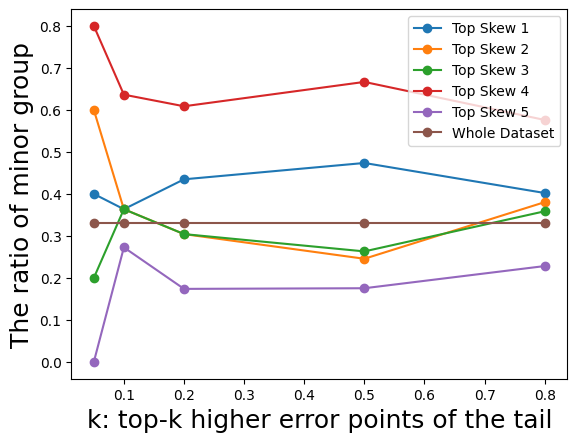

In [11]:
markers = ["o", "o", "o", "o", "o"]
for i in range(5):
    plt.plot(results[results["top_skew"] == i + 1]["score_ratio"], results[results["top_skew"] == i + 1]["tail_err_demo_ratio"], marker=markers[i], label=f"Top Skew {i + 1}")
plt.plot(results[results["top_skew"] == 1]["score_ratio"], results[results["top_skew"] == 1]["total_demo_ratio"], marker="o", label="Whole Dataset")
plt.ylabel("The ratio of minor group", fontsize=18)
plt.xlabel("k: top-k higher error points of the tail", fontsize=18)
plt.legend(fontsize=10)
# plt.savefig("compas_region.eps", format="eps")

In [27]:
# Model score = 0.72
results.groupby("top_skew").mean()[["total_avg_tail_score", "min_avg_tail_score", "maj_avg_tail_score"]]

,total_avg_tail_score,min_avg_tail_score,maj_avg_tail_score
top_skew,,,
1,0.534581,0.543917,0.528128
2,0.673739,0.681025,0.666579
3,0.650791,0.630224,0.663719
4,0.698113,0.729762,0.676237
5,0.552560,0.618258,0.524984
